In [2]:
import os 
os.environ["GIT_PYTHON_REFRESH"] = "quiet" 
#!module load git
import foolbox as fb
import torch
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples

In [3]:
import torchvision
from fastai.vision.all import *

Fix the seed generator

In [4]:
torch.manual_seed(42) 
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Import the MNIST dataset and create the CNN class

In [5]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081))
])
train_set = torchvision.datasets.MNIST('./files/', train=True, download=True, transform=transforms)
test_set = torchvision.datasets.MNIST('./files/', train=False, download=True, transform=transforms)

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=True)

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class CNet(nn.Module):
    def __init__(self):
        super(CNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2)
        x = F.relu(x)
        x = self.drop(self.conv2(x))
        x = F.relu(F.max_pool2d(x, 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
        

In [6]:
class NewNet(nn.Module):
    def __init__(self):
        super(NewNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(800, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop(F.max_pool2d(x, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 800)
        x = self.drop(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

Fastai takes the available device by default

In [8]:
data = DataLoaders(train_loader, test_loader)
learn = Learner(data, CNet(), loss_func=F.nll_loss, opt_func=Adam, metrics=accuracy)

Initial fit for the model

In [9]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.272278,0.254696,0.941200,00:10
1,0.161464,0.149757,0.965200,00:10
2,0.131165,0.133558,0.970500,00:10


Unfreeze and check the optimal learning rate

In [10]:
learn.unfreeze()

SuggestedLRs(valley=tensor(5.2481e-05))

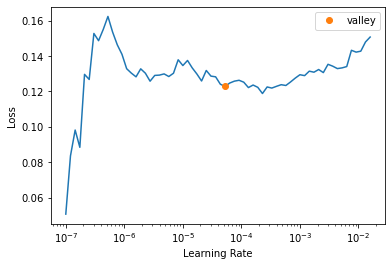

In [11]:
learn.lr_find()

Fit the model again

In [12]:
learn.fit_one_cycle(5, lr_max=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.134623,0.130822,0.968400,00:10
1,0.137548,0.128794,0.972600,00:10
2,0.127663,0.124616,0.971600,00:09
3,0.128819,0.130110,0.970900,00:10
4,0.122989,0.129942,0.970700,00:10


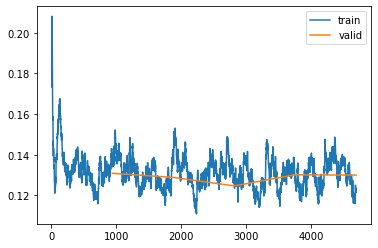

In [13]:
learn.recorder.plot_loss()

Fine tune the model to get the best results

In [14]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.176259,0.160011,0.961800,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.115288,0.101619,0.975900,00:10
1,0.118493,0.103788,0.973500,00:10
2,0.101008,0.082045,0.979700,00:09
3,0.100144,0.070854,0.984400,00:10
4,0.085202,0.066372,0.984100,00:09


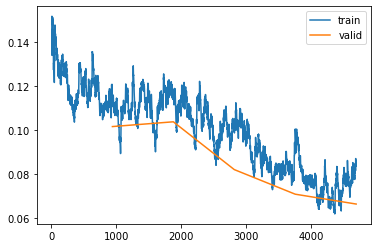

In [15]:
learn.recorder.plot_loss()

Save the model, trained in fastai
By default it is saved in the /models folder with .pth extension

In [157]:
learn.save('./fastai_cnn_NewNet')

Path('models/fastai_cnn_NewNet.pth')

Load the model(fastai) and save it as torch model for foolbox compatibility

In [64]:
model_new = learn.load('fastai_cnn_NewNet')
torch.save(model_new.model.state_dict(), 'fastai_cnn_NewNet_weights.pth')

Load model for the attack

In [8]:
# load the NewNet model
MyModel = NewNet()
MyModel.load_state_dict(torch.load('fastai_cnn_NewNet_weights.pth'))
MyModel.eval()

# load the CNet model
MyModel_1 = CNet()
MyModel_1.load_state_dict(torch.load('fastai_cnn_weights.pth'))
MyModel_1.eval()

CNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (drop): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

Think about preprocess and the attack on the model!!!!!!

In [9]:
#model = torchvision.models.resnet18(pretrained=True).eval()
preprocess = dict(mean=0.1307, std=0.3081)
#preprocess = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
bound = (0, 1)
fmodel_1 = fb.PyTorchModel(MyModel, bounds=bound, preprocessing=preprocess)

In [10]:
fmodel_2 = fb.PyTorchModel(MyModel_1, bounds=bound, preprocessing=preprocess)

In [27]:
images_2, labels_2 = samples(fmodel_2, dataset="mnist", batchsize=100)

Three different attacks with 100 values of epsilons

In [28]:
attack0 = fb.attacks.LinfPGD()
attack1 = fb.attacks.BoundaryAttack()
attack2 = fb.attacks.FGSM()
attack = [attack0, attack1, attack2]
epsilon = np.linspace(0.0, 1, num=100)

Take model 1: Boundary attack with different batchsize

In [51]:
batches = [1, 20, 50, 100, 256, 512, 1024]
succes_rates_1 = []
for i, j in enumerate(batches):
    images, labels = samples(fmodel_2, dataset="mnist", batchsize=j)
    raw, clipped, is_adv1 = attack2(fmodel_2, images, labels, epsilons=epsilon)
    succes_rates_1.append(is_adv1)

/home/venkat31/.conda/envs/n2gem/lib/python3.8/site-packages/foolbox/utils.py:80: UserWarning: samples() has only 20 samples and repeats itself if batchsize > 20
  warnings.warn(


Plot the results:

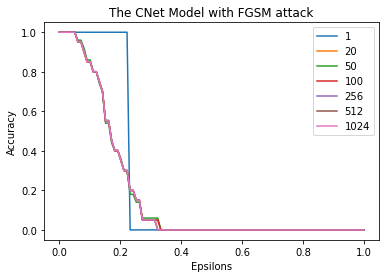

In [52]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for success, labels in zip(succes_rates_1, batches):
    robust_accuracy = 1 - success.cpu().numpy().astype(np.float32).mean(axis=-1)
    ax.plot(epsilon, robust_accuracy, label=labels)
    ax.set_xlabel("Epsilons")
    ax.set_ylabel("Accuracy")
    ax.set_title("The CNet Model with FGSM attack")
    ax.legend()
plt.savefig("CNet_FGSM_attack.png")

In [29]:
succes_rates_1 = []
succes_rates_2 = []

for attacking in attack:
    raw, clipped, is_adv_1 = attacking(fmodel_1, images_1, labels_1, epsilons=epsilon)
    raw1, clipped1, is_adv_2 = attacking(fmodel_2, images_2, labels_2, epsilons=epsilon)
    succes_rates_1.append(is_adv_1)
    succes_rates_2.append(is_adv_2)


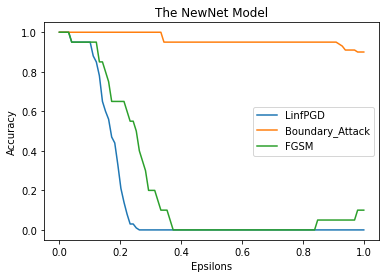

In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
label = ['LinfPGD', 'Boundary_Attack', 'FGSM']
for success, labels in zip(succes_rates_1, label):
    robust_accuracy = 1 - success.cpu().numpy().astype(np.float32).mean(axis=-1)
    ax.plot(epsilon, robust_accuracy, label=labels)
    ax.set_xlabel("Epsilons")
    ax.set_ylabel("Accuracy")
    ax.set_title("The NewNet Model")
    ax.legend()   

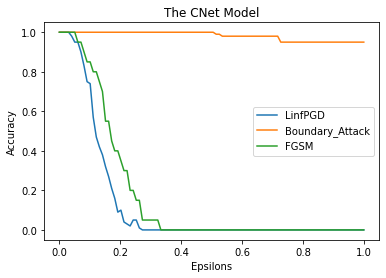

In [31]:
for success, labels in zip(succes_rates_2, label):
    robust_accuracy = 1 - success.cpu().numpy().astype(np.float32).mean(axis=-1)
    plt.plot(epsilon, robust_accuracy, label=labels)
    plt.xlabel("Epsilons")
    plt.ylabel("Accuracy")
    plt.title("The CNet Model")
    plt.legend()   
plt.show()

In [ ]:
robust_accuracy = 1 - is_adv.float32().mean(axis=-1)
print("robust accuracy for perturbations with")
for eps, acc in zip(epsilon, robust_accuracy):
    print(f"  Linf norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")
#print(robust_accuracy)

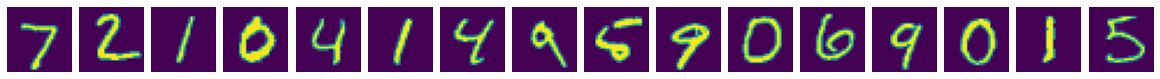

In [108]:
fb.plot.images(images)

In [68]:
# if not used as eagerpy tensor follow this
robust_accuracy = 1 - is_adv.cpu().numpy().astype(np.float32()).mean(axis=-1)
robust_accuracy

1.0